In [4]:
import numpy as np
from numpy.random import seed
from numpy.random import randint

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from pyMSDtorch.core import helpers, custom_losses, train_scripts
from pyMSDtorch.core.networks import MSDNet, MSD_graph_tools
#from pyMSDtorch.test_data import twoD
#from pyMSDtorch.test_data.twoD import build_test_data, torch_hdf5_loader

from torchsummary import summary
import matplotlib.pyplot as plt
import networkx as nx

#from torch.autograd import Variable
#from torch.nn import Module, Sequential, Conv2d # for helper functions

import matplotlib.pyplot as plt
#from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from pytorch_lightning.metrics.classification import F1, Precision, Recall
#from torchvision.utils import save_image
from sklearn.metrics import f1_score
from pytorch_lightning.metrics.classification import F1

import imageio

In [5]:
import napari
#from tifffile import imread

## Load data from file

We load 3d numpy array data that is subsampled from the large tiffs in ZF_TailbudDevelopment.

- Each individual image is of size z=10, x=y=64

- There are 200 training images and 50 images in each of the testing and validation sets.

- A single slice of a training image and its mask are plotted

In [6]:
train_imgs = np.load('microscopy_data/trainimgs.npy')
train_masks = np.load('microscopy_data/trainmasks.npy')

test_imgs = np.load('microscopy_data/testimgs.npy')
test_masks = np.load('microscopy_data/testmasks.npy')

val_imgs = np.load('microscopy_data/validationimgs.npy')
val_masks = np.load('microscopy_data/validationmasks.npy')

print('Training image array shape:   ', train_imgs.shape)
print('Testing image array shape:    ', test_imgs.shape)
print('Validation image array shape: ', val_imgs.shape)

Training image array shape:    (100, 10, 64, 64)
Testing image array shape:     (30, 10, 64, 64)
Validation image array shape:  (30, 10, 64, 64)


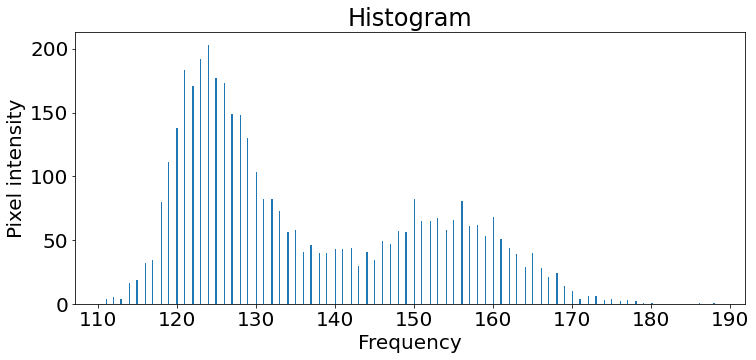

In [7]:
img_num = 0

plt.figure(figsize=(12,5))
plt.rcParams.update({'font.size': 20})

plt.subplot(121)
plt.imshow(train_imgs[img_num,0,:,:]); plt.colorbar(fraction=0.046, pad=0.04); plt.title('Ground Truth'); 
plt.subplot(122);
plt.imshow(train_masks[img_num,0,:,:]); plt.colorbar(fraction=0.046, pad=0.04); plt.title('Mask'); 

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.rcParams.update({'font.size': 20})
plt.hist((train_imgs[img_num,0,:,:].flatten()), bins=500); plt.title('Histogram'); 
plt.xlabel('Frequency')
plt.ylabel('Pixel intensity')
plt.show()

## Prep data for MSDNet ingestion

Below, we convert all numpy arrays to tensors use load them inot the popular pyTorch DataLoader class.

Parameters to define:

1. batch_size: size of batch in each training loop
2. shuffle: tells DataLoader to randomize each tensor along dimension 0

In [ ]:
batch_size = 50
shuffle = True

# Convert all data to tensors
train_imgs = torch.Tensor(train_imgs)
train_masks = torch.Tensor(train_masks)
test_imgs = torch.Tensor(test_imgs)
test_masks = torch.Tensor(test_masks)
val_imgs = torch.Tensor(val_imgs)
val_masks = torch.Tensor(val_masks)

# Store tensors and corresponding labels
train_loader = TensorDataset(train_imgs, train_masks)
test_loader = TensorDataset(test_imgs, test_masks)
val_loader = TensorDataset(val_imgs, val_masks)

# Iterable Dataloader class for easy access
loader_params = {'batch_size': batch_size, 'shuffle': shuffle}
train_loader = DataLoader(train_loader, **loader_params)
test_loader = DataLoader(test_loader, **loader_params)
validation_loader = DataLoader(val_loader, **loader_params)

## Define Mixed Scale Dense Network

We define an instance of the MSDNet class in the variable 'net'

Important parameters:

1. in_channels/out_channels: keep at 1 since images are grayscale (dimensions are [batch_size, in/out channels, z, x, y])
2. num_layers: defining parameter of MSDNet; dictates length of network and governs number of parameters (parameters grow as O(num_layers^2))
3. layer_width: number of channels in each layer; we keep at 1, as no benefit has been found for any other integer
4. max_dilation: typically 10; the max dialation MSDNet cycles through
5. normalization: change to nn.BatchNorm2d for 2d segmentation
6. convolution: change to nn.Conv2d for 2d segmentation
7. final_layer: activation function applied to network output; nn.Sigmoid chosen for BCEloss (chosen below)

In [ ]:
in_channels = 1
out_channels = 1
num_layers = 12   # main parameter to toggle
layer_width = 1  
max_dilation = 8          
activation = nn.ReLU()
normalization = nn.BatchNorm3d
final_layer = nn.Sigmoid()
convolution=nn.Conv3d

net = MSDNet.MixedScaleDenseNetwork(in_channels = in_channels,
                                    out_channels = out_channels, 
                                    num_layers=num_layers, 
                                    layer_width=layer_width,
                                    max_dilation = max_dilation, 
                                    activation=activation,
                                    normalization=normalization,
                                    convolution=convolution,
                                    final_layer=final_layer
                                   )
#print(net)
#summary(net, (in_channels,32,32, 32))

## Training loop definition

Loop through epochs. In each epoch, loop through training data/track gradients and compute training and validaiton losses

**Explore here if you're curious about how PyTorch works**

In [ ]:
def train_segmentation(net, trainloader, validationloader, NUM_EPOCHS,
          criterion, optimizer, show=0):
    """
    Loop through epochs passing noisy images to net.

    Input:
        net -- The neural network
        trainloader -- Set of data to train.
        validationloader -- Set of data used to validate the model
        NUM_EPOCHS -- number of training epochs
        criterion -- Pytorch loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions
                     OR check out pyMSDtorch/core/loss_functions.py for custom binary loss functions
        optimizer -- Pytorch optimizers: https://pytorch.org/docs/stable/optim.html
        show -- print out training/validation losses for every nth epoch
    """
    train_loss = []
    validation_loss = []
    device = helpers.get_device()
    

    for epoch in range(NUM_EPOCHS):
        running_train_loss = 0.0
        running_validation_loss = 0.0

        for data in trainloader:  # loop through each batch
            noisy, target = data  # load noisy and target images

            noisy = noisy.type(torch.FloatTensor)    # Cast data as tensor of floats
            target = target.type(torch.FloatTensor)
            noisy = noisy.to(device).unsqueeze(1) 
            target = target.to(device).unsqueeze(1)

            # For multiclass segmentation using Cross Entropy, PyTorch requires 
            # the target to be a tensor of Longs
            if criterion.__class__.__name__ == 'CrossEntropyLoss':
                print('in the loop')
                target = target.type(torch.LongTensor)  
                target = target.to(device)
                target = target.squeeze(1)  # Get rid of dimension along channels


            # forward pass, compute loss and accuracy    
            output = net(noisy)

            loss = criterion(output, target)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # update the parameters
            optimizer.step()
            running_train_loss += loss.item()

        # Compute validation step. torch.no_grad() makes sure we don't touch gradients
                        
        #net.eval()  # Switches network to evaluation mode. Don't use if using batchnorm
        with torch.no_grad():
            for x, y in validationloader:
                x = x.to(device).unsqueeze(1)
                y = y.to(device).unsqueeze(1)
                
                if criterion.__class__.__name__ == 'CrossEntropyLoss':
                    y = y.type(torch.LongTensor)
                    y = y.to(device).squeeze(1)

                # forward pass, compute validation loss and accuracy
                yhat = net(x)
                val_loss = criterion(yhat, y)

                # update running validation loss and accuracy
                running_validation_loss += val_loss.item()

        loss = running_train_loss / len(trainloader)
        val_loss = running_validation_loss / len(validationloader)

        train_loss.append(loss)
        validation_loss.append(val_loss)

        if show != 0:
            if np.mod(epoch + 1, show) == 0:
                print(f'Epoch {epoch + 1} of {NUM_EPOCHS} | Training Loss: {loss:.4f} | Validation Loss: {val_loss:.4f}')

    return net, train_loss, validation_loss

## Define training parameters and train

Here we train the network and print losses.

Parameters to define:

1. epochs: length of training loop
2. learning_rate: step size for computing gradients
3. criterion: we use pytorch's built-in binary cross entropy loss
4. optimizer: we use built-in Adam optimizer (SGD doesn't seem to work well here)
5. device: pytorch automatically detects CPU or cuda GPU

In [ ]:
epochs = 50
learning_rate = 5e-2

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

device = helpers.get_device()
print('Device we will compute on: ', device)   # cuda:0 for GPU. Else, CPU
net.to(device)   # send network to GPU

In [ ]:
net, train_loss, validation_loss = train_segmentation(
    net,train_loader, validation_loader, epochs, 
    criterion, optimizer, show=5)   # training happens here

In [ ]:
# Plot losses
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 16})

plt.plot(train_loss, linewidth=2, label='training')
plt.plot(validation_loss, linewidth=2, label='validation')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.title('MSDNet with ReLU and BatchNorm')
plt.legend()
plt.tight_layout()
#plt.savefig(save_directory + '/losses')
plt.show()

In [ ]:
# Clears memory cache
torch.cuda.empty_cache()

## Segment testing set data

Testing set data is passed through the network via the test_loader class definied earlier.

Some notes:

- Variety of metrics computed, including F1 scores
- torch.no_grad() tells pytorch to ignore gradients, as we are no longer training
- 2d slices are plotted for reference (Input/Prediction/Mask)
- Results saved in lists seg_imgs/rounded_imgs
- The network parameters are saved using torch.save
- Lastly, we choose a stack to view in Napari

In [ ]:
# Where to save results
resultpath = 'dummy'
segpath = resultpath + '/seg'
roundpath = resultpath + '/round'
inputpath = resultpath + '/input'
maskpath = resultpath + '/mask'

helpers.make_dir(resultpath)
helpers.make_dir(segpath)
helpers.make_dir(roundpath)
helpers.make_dir(inputpath)
helpers.make_dir(maskpath)

In [ ]:
accF1 = 0
microF1 = 0
macroF1 = 0
wmacroF1 = 0
counter = 0

metricF1 = F1(1)

seg_imgs = []
rounded_imgs = []
noisy_imgs = []
target_imgs = []

counter = 0

num_images = 0
num_images = np.min((num_images, batch_size))

with torch.no_grad():
    
    for batch in test_loader:
        #net.eval()   # again, this ignores the batchnorm parameters
        noisy, target = batch
        #print(noisy)

        noisy = noisy.type(torch.FloatTensor)
        target = target.type(torch.IntTensor)

        noisy = noisy.to(device).unsqueeze(1)
        target = target.to(device).unsqueeze(1)

        output = net(noisy)
        rounded = torch.round(output)

        #show_me = torch.argmax(output.cpu().data, dim=1)
        show_me = output.squeeze(1)
        rounded = rounded.squeeze(1)
        noisy = noisy.squeeze(1)
        target = target.squeeze(1)

        for j in range(1):
            plt.figure(figsize=(22,5))
            plt.subplot(131)
            plt.imshow(noisy.cpu()[j,0,:,:].data); plt.colorbar(shrink=0.8); plt.title('Input');             
            plt.subplot(132)            
            #show_me = torch.argmax(output.cpu()[j,:,:,:].data, dim=0)            
            #plt.imshow(output.cpu()[j,0,0,:,:]); plt.colorbar(shrink=0.8); plt.title('Prediction');            
            plt.imshow(show_me.cpu()[j,0,:,:]); plt.colorbar(shrink=0.8); plt.title('Prediction');            
            plt.subplot(133)            
            plt.imshow(target.cpu()[j,0,:,:].data); plt.colorbar(shrink=0.8); plt.title('Mask');  
            plt.rcParams.update({'font.size': 18})
            plt.tight_layout()
            #save_name = path + f'/batch{counter}_num{j}'
            #plt.savefig(save_name)
            plt.show()

        for j in range(show_me.size()[0]):
            seg_imgs.append(show_me[j,:].detach().cpu())
            
        for j in range(rounded.size()[0]):
            rounded_imgs.append(rounded[j,:].detach().cpu())

        for j in range(noisy.size()[0]):
            noisy_imgs.append(noisy[j,:].cpu())

        for j in range(target.size()[0]):
            target_imgs.append(target[j,:].cpu())

        counter+=1
        show_me = torch.argmax(output.cpu()[:,:,:,:].data, dim=1)
        #rounded = torch.round(output)

        accF1 += metricF1(rounded.detach().cpu(), target.detach().cpu())
        microF1 += f1_score(target.flatten().cpu(), show_me.flatten(), average='micro')
        macroF1+= f1_score(target.flatten().cpu(), show_me.flatten(), average='macro')
        wmacroF1 += f1_score(target.flatten().cpu(), show_me.flatten(), average='weighted')
    
    

In [ ]:
# Save each results as a tiff
for j in range(len(seg_imgs)):
    
    filename = f'/seg_{j}.tif'
    imageio.mimwrite(segpath + filename, seg_imgs[j])
    
    filename = f'/rounded_{j}.tif'
    imageio.mimwrite(roundpath + filename, rounded_imgs[j])
    #print(seg_imgs[0].size())
    
    filename = f'/input_{j}.tif'
    imageio.mimwrite(inputpath + filename, noisy_imgs[j])
    
    filename = f'/mask_{j}.tif'
    imageio.mimwrite(maskpath + filename, target_imgs[j])


In [ ]:
# Print metrics and empty cache

accF1 = accF1 / len(test_loader)
microF1 = microF1 / len(test_loader)
macroF1 = macroF1 / len(test_loader)
wmacroF1 = wmacroF1 / len(test_loader)

print('F1 score is :               ', accF1)
print('Micro F1 score is :         ', microF1 )
print('Macro F1 score is :         ', macroF1 )
print('Weighted macro F1 score is :', wmacroF1 )

torch.cuda.empty_cache()

In [ ]:
# Save trained network

model_output_name = '/state_dict_net.pt'
torch.save(net.state_dict(), 'network_params')
#torch.save(net, model_output_name)

In [ ]:
# View results in Napari

img_num = 5
viewer = napari.view_image(noisy_imgs[img_num].numpy(), colormap='gray', name='Input')
tmp = viewer.add_image(seg_imgs[img_num].numpy(), colormap="magma", name='Prediction')
tmp = viewer.add_labels(target_imgs[img_num].numpy(), name='Labels')

In [ ]:
print(len(seg_imgs))
print(seg_imgs[5].shape)